In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import sys
import glob
import os
[sys.path.append(x) for x in glob.glob('../utils/*')]
from plotting_utils import figSize
from hmm import HMMRecalibration
from hmm_utils import *
from simulation import *
from simulation_utils import * 


# for a reproducible result
np.random.seed(1)

fig_path    = FIG_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [3]:
base_opts = dict()
base_opts['alpha']          = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
base_opts['delT']           = 0.02 # define the time step (20 ms)
base_opts['nDelaySteps']    = 10   # define the simulated user's visual feedback delay (200 ms)
base_opts['nSimSteps']      = 20000
base_opts['nUnits']         = 192
base_opts['SNR']            = 1
base_opts['possibleGain']   = np.linspace(0.1,2.5,10)
base_opts['center_means']   = False
base_opts['nTrainingSteps'] = 10000


cfg     = initializeBCI(base_opts)
results = simulateBCIFitts(cfg) 

/home/users/ghwilson/projects/nonstationarities/utils/simulation/simulation.py:299: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = getNeuralTuning(currControl, decode_params)
/home/users/ghwilson/projects/nonstationarities/utils/simulation/simulation.py:302: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = getDecodedControl(simAct, decode_params)


In [4]:
import copy 

# Simulate BCI performance with matched neural tuning and decoder, and an optimized gain
                    
cfg_pauses                      = copy.deepcopy(cfg)
cfg_pauses['pause_likelihood']  = 0.009
results_pauses                  = simulateBCIFitts(cfg_pauses)  

cfg_retargeting                     = copy.deepcopy(cfg_pauses)
cfg_retargeting['newtarg_on_pause'] = 1
results_retargeting                 = simulateBCIFitts(cfg_retargeting)  

In [5]:
def plotTrials(results, n_plot =  10):
    n_trls = len(results['trialStart'])

    starts = np.concatenate([results['trialStart'], [results['posTraj'].shape[0] - 1]])
    for j in np.random.choice(n_trls, min(n_plot, n_trls), replace = False):
        start = starts[j]
        stop  = starts[j + 1]
        targ        = results['targTraj'][stop, :] 
        trl_cursor  = results['posTraj'][start:stop, :] - results['posTraj'][start, :]

        _ = plt.scatter(trl_cursor[:, 0], trl_cursor[:, 1], color = 'k', s = 3, alpha = 0.1)


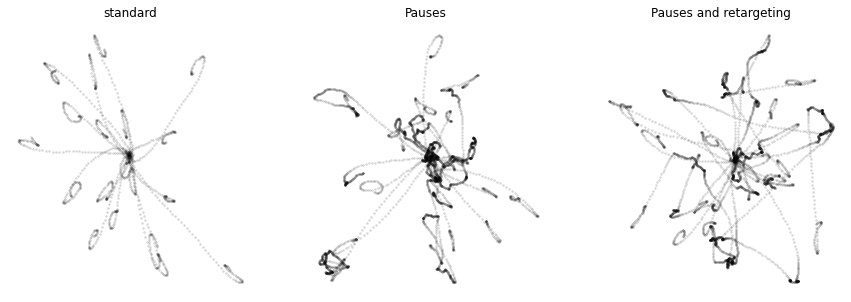

In [12]:
figSize(5, 15)

labels = ['standard', 'Pauses', 'Pauses and retargeting']

for i, dat in enumerate([results, results_pauses, results_retargeting]):
    plt.subplot(1, 3, i + 1)
    plotTrials(dat, n_plot = 20)
    plt.axis('off')
    plt.title(labels[i])
    
#plt.subplot(1,3,3)
#sns.kdeplot(results['ttt'])
#sns.kdeplot(results_pauses['ttt'])
#plt.legend(['Standard', 'Pauses'])

plt.show()

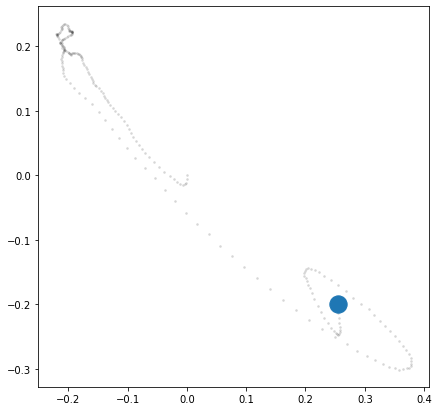

In [95]:
figSize(7, 7)
n_plot = 1


clicks = np.zeros((dat['posTraj'].shape[0]))
clicks[dat['trialStart']] = 1
rti_x, rti_y, idxs = rti.label(neural = dat['neuralTraj'], cursor = dat['posTraj'],
                               click_state =clicks, return_indices=True)

n_trls = len(dat['trialStart'])

starts = np.concatenate([dat['trialStart'], [dat['posTraj'].shape[0] - 1]])
for j in np.random.choice(n_trls, min(n_plot, n_trls), replace = False):
    start = starts[j]
    stop  = starts[j + 1]
    targ        = dat['targTraj'][start, :] - dat['posTraj'][start, :]
    trl_cursor  = dat['posTraj'][start:stop, :] - dat['posTraj'][start, :]

    _ = plt.scatter(trl_cursor[:, 0], trl_cursor[:, 1], color = 'k', s = 3, alpha = 0.1)
    
    
    targ        = dat['targTraj'][stop-1, :] - dat['posTraj'][start, :]
    plt.scatter(targ[0], targ[1], s = 300)
    

Pause proportion:  0.54


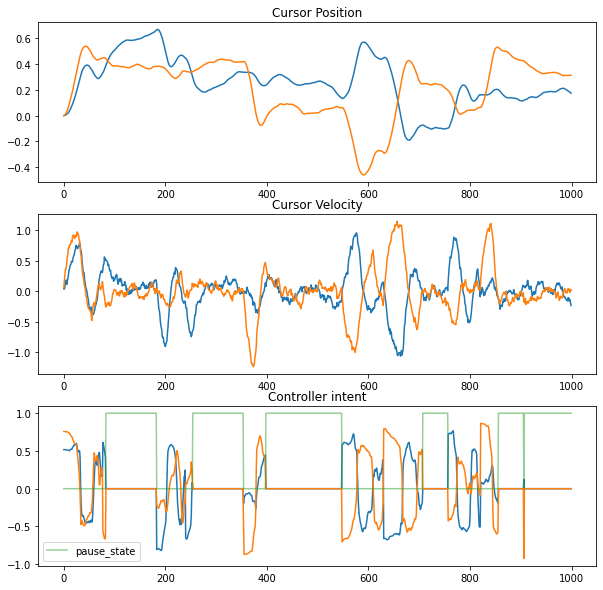

In [7]:
figSize(10, 10)

print('Pause proportion: ', np.mean(results_pauses['pauseTraj']))

timerange = np.arange(1000)

plt.subplot(3, 1, 1)
plt.plot(results_pauses['posTraj'][timerange, :])
plt.title('Cursor Position')

plt.subplot(3, 1, 2)
plt.plot(results_pauses['velTraj'][timerange, :])
plt.title('Cursor Velocity')


plt.subplot(3, 1, 3)
plt.plot(results_pauses['conTraj'][timerange, :])
plt.plot(results_pauses['pauseTraj'][timerange, :], alpha = 0.5, label = 'pause_state')
plt.title('Controller intent')
plt.legend()

plt.show()

### Systematic performance comparison

In [108]:
from utils.recalibration import hmm_utils
from utils.recalibration.RTI_utils import RTI
from utils.simulation import simulate_RTIRecalibration, simulate_HMMRecalibration


# PRI-T settings:
hmm_opts = dict()
hmm_opts['probThresh']  = 'probWeighted'
hmm_opts['gridSize']    = 20
hmm_opts['stayProb']    = 0.999
hmm_opts['adjustKappa'] = lambda x: 1 / (1 + np.exp(-1 * (x - 0.2) * 1))
hmm_opts['vmKappa']     = 4


# RTI settings:
rti_opts = dict()
rti_opts['look_back'] = 320
rti_opts['min_dist']  = 0.1
rti_opts['min_time']  = 30


rti = RTI(rti_opts['look_back'], rti_opts['min_dist'], rti_opts['min_time'])

targLocs                = hmm_utils.generateTargetGrid(gridSize = hmm_opts['gridSize'], is_simulated=True)
stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(gridSize = hmm_opts['gridSize'], 
                                                             stayProb = hmm_opts['stayProb'])
hmm                     = HMMRecalibration(stateTrans, targLocs, pStateStart, hmm_opts['vmKappa'],
                                           adjustKappa = hmm_opts['adjustKappa'])

In [109]:
import pandas as pd 

base_opts = dict()
base_opts['alpha']          = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
base_opts['delT']           = 0.02 # define the time step (20 ms)
base_opts['nDelaySteps']    = 10   # define the simulated user's visual feedback delay (200 ms)
base_opts['nSimSteps']      = 20000
base_opts['nUnits']         = 192
base_opts['SNR']            = 0.5
base_opts['possibleGain']   = np.linspace(0.1,2.5,10)
base_opts['center_means']   = False
base_opts['nTrainingSteps'] = 10000

#cfg['pause_likelihood']  = 0.004
#cfg['newtarg_on_pause']  = 1


nReps = 200

errors_df = pd.DataFrame(columns=['error','paused','method'])
for i in range(nReps):
    for j, pause_type in enumerate(['regular', 'pauses', 'pauses_retargeting']):
        
        if pause_type == 'regular':
            cfg['pause_likelihood']  = 0
        elif pause_type == 'pauses':
            cfg['pause_likelihood'] = 0.009
            cfg['newtarg_on_pause'] = False
        elif pause_type == 'pauses_retargeting':
            cfg['pause_likelihood'] = 0.009
            cfg['newtarg_on_pause'] = True
        else:
            raise ValueError
        
        cfg    = initializeBCI(base_opts) 
        D_rti  = simulate_RTIRecalibration(cfg, rti)
        D_prit = simulate_HMMRecalibration(cfg, hmm)

        for k, D in enumerate([D_rti, D_prit]):
            method = 'RTI' if k == 0 else 'PRI-T' 
            err    = np.corrcoef(D[1:, :].flatten(), cfg['neuralTuning'][:, 1:].flatten())[0, 1]
            errors_df.loc[len(errors_df.index)] = [err, pause_type, method]

    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


<AxesSubplot: xlabel='paused', ylabel='error'>

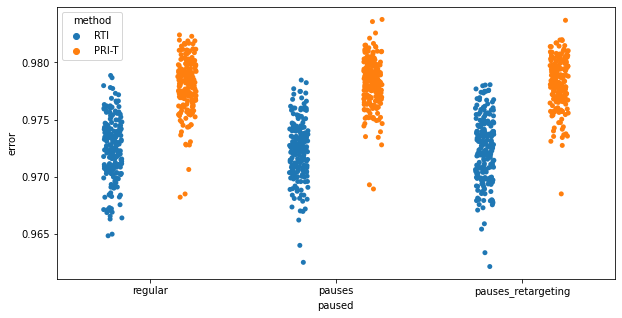

In [110]:
figSize(5, 10)
sns.stripplot(data = errors_df, x = 'paused', y = 'error', hue = 'method', dodge=True)
#sns.boxplot(data = errors_df, x = 'method', y = 'error', hue = 'paused', dodge=True)

In [105]:
look_back = 'prior_click'

assert look_back =='prior_click' or look_back >= 0, "look_back parameter must be nonnegative"
